In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math
from SALib.sample import saltelli
from SALib.analyze import sobol

In [16]:
# Parameter values

Target_cell_number = 5e3
r_ab = 1.25e-6 # in cm
E_T_ratio = 10
t_end = 10
t = np.geomspace(1e-10, t_end, 500)
tspan = [1e-10, t_end]
t_end1 = 1
t1 = np.geomspace(1e-10, t_end1, 100)
t_span1 = [0, t_end1]

In [17]:
def single_cell_model(t, z, Ainit, rtot, kon, koff, D_t):
    k1 = Ainit*kon
    k2 = 4*D_t/(math.pi*((r_ab)**2))
    Atot = 1e16*Ainit/Target_cell_number
    beta = Atot/rtot
    alpha1 = k1/koff
    alpha2 = k2/koff

    dA1 = 2*alpha1*(1-z[0]-2*z[1])*(beta-z[0]-z[1]) - z[0] - alpha2*(1-z[0]-2*z[1])*z[0] + 2*z[1]
    dA2 = alpha2*(1-z[0]-2*z[1])*z[0] - 2*z[1]

    return [dA1, dA2]

def NK_cell(t, z, A_0, Atot_system, E_T_ratio, rtot_f, qon, qoff, koff):
    q = A_0*qon
    sigma = q/koff
    epsilon = qoff/koff
    Atot_effector = Atot_system/E_T_ratio
    eta = Atot_effector/rtot_f

    return sigma*(eta-z)*(1-z) - epsilon*z

def single_cell_stst(A_0, rtot, kon, koff, D_t):

    z0 = [0, 0]

    # solve single cell model to obtain equilibrium values
    # to use as ics for A10 and A20 in two cell model
    z = solve_ivp(single_cell_model, tspan, z0, method='Radau', args=(A_0, rtot, kon, koff, D_t), t_eval=t)
    A1 = z.y[0]
    A2 = z.y[1]
    A1_stst = A1[-1]
    A2_stst = A2[-1]
    
    return [A1_stst, A2_stst]

def NK_cell_IC(A_0, A1_stst, A2_stst, E_T_ratio, rtotff, rtott, qon, qoff, koff):

    Atot = 1e16*A_0/Target_cell_number
    beta = Atot/rtott

    A0 = beta - A1_stst - A2_stst
    A0_IC = A0*Atot

    z1 = solve_ivp(NK_cell, t_span1, [0], method='Radau', args=(A_0, A0_IC, E_T_ratio, rtotff, qon, qoff, koff), t_eval=t1)

    A1f = z1.y[0]

    return A1f[-1]

def two_cells(t, z, A_0, A10_0, A20_0, A01_0, kon, koff, qon, qoff, rtot_t, rtot_f, D_t, D_f):

    Ainit = A_0
    k1 = Ainit*kon
    k3 = qon*Ainit
    k2 = 4*D_t/(math.pi*((r_ab)**2))
    k6=k2
    k7 = 4*D_t/(math.pi*((r_ab/2)**2))
    k4 = D_f/(math.pi*((r_ab)**2))
    k5 = D_f/(math.pi*((r_ab/2)**2))

    alpha1 = k1/koff
    alpha2 = k2/koff
    alpha3 = k3/koff
    alpha4 = k4/koff
    alpha5 = k5/koff
    alpha6 = k6/koff
    alpha7 = k7/koff

    gamma = qoff/koff
    rtot_t = rtot_t*0.035
    rtot_f = rtot_f/4
    phi = rtot_t/rtot_f

    beta_synapse = 1e1*Ainit
    beta_t = beta_synapse + A10_0 + A20_0 + (A01_0/phi)
    beta_f = phi*beta_t
    
    A00 = (1 - (1/beta_t)*(z[0] + z[1] + z[3] + z[4] + (1/phi)*z[2]))
    rt = 1- z[0] - z[3] - 2*(z[1] + z[4])
    rf = 1 - z[2] - phi*(z[3] + z[4])
    
    dA10 = alpha1*beta_t*(A00)*(rt) - z[0] - alpha2*z[0]*(rt) + 2*z[1] - alpha4*z[0]*(rf) + gamma*z[3]
    dA20 = alpha2*z[0]*(rt) - 2*z[1] - alpha5*z[1]*(rf) + 2*gamma*z[4]
    dA01 = alpha3*beta_f*(A00)*(rf) - gamma*z[2] - alpha6*z[2]*(rt) + phi*z[3]
    dA11 = alpha4*z[0]*(rf) - gamma*z[3] + (alpha6/phi)*z[2]*(rt) - z[3] - alpha7*z[3]*(rt) + 2*z[4]
    dA21 = alpha5*z[1]*(rf) - 2*gamma*z[4] + alpha7*z[3]*(rt) - 2*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [18]:
def calc_fc(A_0, kon, koff, qon, qoff, rtot_t, rtot_f, D_t, D_f):

    ICS = single_cell_stst(A_0, rtot_t, kon, koff, D_t)
    A10_0 = ICS[0]
    A20_0 = ICS[1]
    A01_0 = NK_cell_IC(A_0, A10_0, A20_0, E_T_ratio, rtot_f, rtot_t, qon, qoff, koff)
    z0 = [A10_0, A20_0, A01_0, 0, 0]
    z = solve_ivp(two_cells, tspan, z0, method='Radau', t_eval=t, args=(A_0, A10_0, A20_0, A01_0, kon, koff, qon, qoff, rtot_t, rtot_f, D_t, D_f))
    A11 =  z.y[3]
    A21 = z.y[4]

    fc = np.max(A11 + A21)
    
    return fc

In [19]:
problem = {
    'num_vars': 8,
    'names': ['kon', 'koff', 'qon', 'qoff', 'rtot_t', 'rtot_f', 'D_t', 'D_f'],
    'bounds': [[1e3, 1e7],
               [5e-5, 5e-4],
               [8e3, 1e5],
               [5e-3, 1e-1],
               [5e4, 1e6],
               [4e4, 3e5],
               [5e-11, 5e-9],
               [7.4e-11, 7.4e-9]]
}

In [20]:
vals = saltelli.sample(problem, 2048)

Y = np.zeros(len(vals))
indicies = []
A0s = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

for A0 in A0s:
    for i in range(len(vals)):
        params = vals[i]
        kon = params[0]
        koff = params[1]
        qon = params[2]
        qoff = params[3]
        rtot_t = params[4]
        rtot_f = params[5]
        D_t = params[6]
        D_f = params[7]
        Y[i] = calc_fc(A0, kon, koff, qon, qoff, rtot_t, rtot_f, D_t, D_f)
    Si = sobol.analyze(problem, Y)
    indicies.append(Si['ST'])

In [21]:
kon_si = np.zeros(len(A0s))
koff_si = np.zeros(len(A0s))
qon_si = np.zeros(len(A0s))
qoff_si = np.zeros(len(A0s))
rtot_t_si = np.zeros(len(A0s))
rtot_f_si = np.zeros(len(A0s))
D_t_si = np.zeros(len(A0s))
D_f_si = np.zeros(len(A0s))

for i in range(len(indicies)):
    vals = indicies[i]
    kon_si[i] = vals[0]
    koff_si[i] = vals[1]
    qon_si[i] = vals[2]
    qoff_si[i] = vals[3]
    rtot_t_si[i] = vals[4]
    rtot_f_si[i] = vals[5]
    D_t_si[i] = vals[6]
    D_f_si[i] = vals[7]


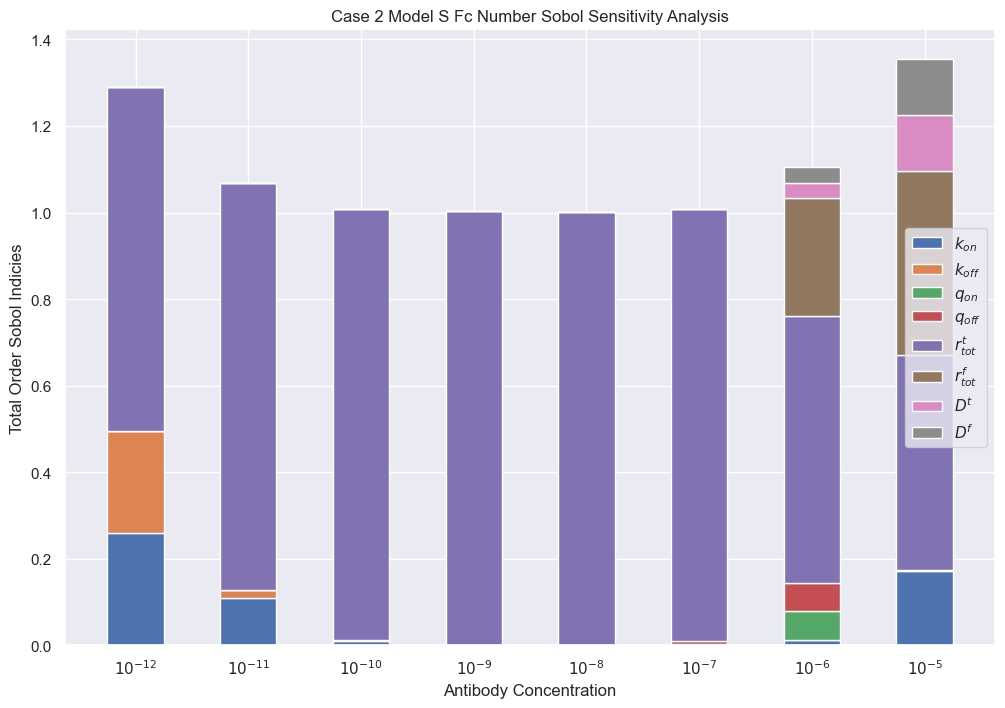

In [22]:
ab_conc = (r'$10^{-12}$', r'$10^{-11}$', r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$')

param_indicies = {
    r"$k_{on}$": kon_si,
    r"$k_{off}$": koff_si,
    r"$q_{on}$": qon_si,
    r"$q_{off}$": qoff_si,
    r"$r_{tot}^t$": rtot_t_si,
    r"$r_{tot}^f$": rtot_f_si,
    r"$D^t$": D_t_si,
    r"$D^f$": D_t_si
}

sns.set_theme()

width = 0.5
fig, ax = plt.subplots(figsize=(12,8))
bottom = np.zeros(8)

for boolean, param_indicie in param_indicies.items():
    p = ax.bar(ab_conc, param_indicie, width, label=boolean, bottom=bottom)
    bottom += param_indicie

ax.set_title('Case 2 Model S Fc Number Sobol Sensitivity Analysis')
ax.legend(loc='best')
ax.set_xlabel('Antibody Concentration')
ax.set_ylabel('Total Order Sobol Indicies')
plt.show()